# This is the Saildrone and MUR collocation code. 


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr

def get_sat_filename(date):
    dir_sat='F:/data/sst/jpl_mur/v4.1/'
    syr, smon, sdym, sjdy = str(date.dt.year.data), str(date.dt.month.data).zfill(2), str(date.dt.day.data).zfill(2), str(date.dt.dayofyear.data).zfill(2)
    sat_filename =dir_sat + syr + '/'+ sjdy + '/' + syr + smon + sdym + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
    exists = os.path.isfile(sat_filename)
    return sat_filename, exists


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

In [19]:
filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30',ds_usv.time[-1].data))  #first part of data is when USV being towed, elminiate
ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
ds_usv_subset = ds_usv.dropna(dim='time',subset={'UWND_MEAN'})   #get rid of all the nan
#print(ds_usv_subset.UWND_MEAN[2000:2010].values)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all data for that period

In [26]:
read_date,end_date = ds_usv_subset.time.min(),ds_usv_subset.time.max()
filelist = []
while read_date<=(end_date+np.timedelta64(1,'D')):
    tem_filename,exists = get_sat_filename(read_date)
    if exists:
        filelist.append(tem_filename)
    read_date=read_date+np.timedelta64(1,'D')
print(filelist[0])

F:/data/sst/jpl_mur/v4.1/2018/101/20180411090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


# Read in MUR data
Read in data using open_mfdataset with the option coords='minimal'

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [27]:
ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 62)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2018-04-11T09:00:00 ... 2018-06-11T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<shape=(62, 17999, 36000), chunksize=(1, 17999, 36000)>
    analysis_error    (time, lat, lon) float32 dask.array<shape=(62, 17999, 36000), chunksize=(1, 17999, 36000)>
    mask              (time, lat, lon) float32 dask.array<shape=(62, 17999, 36000), chunksize=(1, 17999, 36000)>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<shape=(62, 17999, 36000), chunksize=(1, 17999, 36000)>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<shape=(62, 17999, 36000), chunksize=(1, 17999, 36000)>
Attributes:
    Conventions:                CF-1.5
    title:                   

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons

1. Now load the data into memory (de-Dask-ify) it  


In [28]:
#Step 1 from above
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
subset.load()
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [65]:
ds_tem.dims['time']

17583

In [70]:
index=302
cond0 = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index]) 
            & (ds_tem.time.dt.day[index:index+1000]==ds_collocated_nearest.time.dt.day[index])
            & (ds_tem.time.dt.hour[index:index+1000]==ds_collocated_nearest.time.dt.hour[index]))
cond = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index]) 
            & (ds_tem.time.dt.day[index:index+1000]==ds_collocated_nearest.time.dt.day[index])
            & (ds_tem.time.dt.hour[index:index+1000]==ds_collocated_nearest.time.dt.hour[index]))
cond = np.append(np.full(index,True),cond)
cond = np.append(cond,np.full(ilen-index-1000,True))
cond.shape
print(cond0[0:5].data)
print(cond[index:index+5])

[ True  True False False False]
[ True  True False False False]


In [75]:
print(ds_collocated_nearest.analysed_sst[300:310].data)
print(ds_collocated_nearest.time.dt.day[300:310].data)
index=302
ilen = ds_tem.dims['time']
#cond = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index]) 
#            & (ds_tem.time.dt.day[index:index+1000]==ds_collocated_nearest.time.dt.day[index])
#            & (ds_tem.time.dt.hour[index:index+1000]==ds_collocated_nearest.time.dt.hour[index]))
cond = ((ds_tem.analysed_sst[index:index+1000]==ds_collocated_nearest.analysed_sst[index]) 
            & (ds_tem.time.dt.day[index:index+1000]==ds_collocated_nearest.time.dt.day[index])
            & (ds_tem.time.dt.hour[index:index+1000]==ds_collocated_nearest.time.dt.hour[index]))
#cond = np.append(np.full(index,True),cond)
#cond = np.append(cond,np.full(ilen-index-1000,True))
print(cond[index:index+10].data)
print(np.logical_not(cond[index+10]).data)
masked_usv = ds_usv_subset.where(cond,drop=True)


[286.13498 286.14398 286.109   286.109   286.11    286.11    286.047
 286.038   286.038   286.02798]
[12 12 12 12 12 12 12 12 12 12]
[False False False False False False False False False False]
True


In [51]:
ds_collocated_nearest
#print(ds_collocated_nearest.uwnd[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].data)
#print(masked_usv.UWND_MEAN[244:315].mean().data)
#print(masked_usv.time.min().data)
#print(masked_usv.time.max().data)
#print(masked_usv.lon.min().data)
#print(masked_usv.lon.max().data)
#print(masked_usv.time[0].data,masked_usv.time[-1].data)

<xarray.Dataset>
Dimensions:           (time: 17583)
Coordinates:
    lat               (time) float64 37.82 37.82 37.82 ... 37.78 37.78 37.78
    lon               (time) float64 -122.5 -122.5 -122.5 ... -122.3 -122.3
  * time              (time) datetime64[ns] 2018-04-11T18:30:00 ... 2018-06-11T05:34:00
    trajectory        float32 1002.0
Data variables:
    analysed_sst      (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    analysis_error    (time) float32 nan nan nan nan nan ... nan nan nan nan nan
    mask              (time) float32 nan nan nan nan nan ... 2.0 2.0 2.0 2.0 2.0
    sea_ice_fraction  (time) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propul

In [ ]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, dlat, dlon, dut = [],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.analysed_sst[index]):
        continue
    if np.isnan(ds_tem.analysed_sst[index]):
        continue
    print(index, ilen)
    cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]) 
            & (ds_tem.time.dt.day==ds_collocated_nearest.time.dt.day[index])
            & (ds_tem.time.dt.hour==ds_collocated_nearest.time.dt.hour[index]))
    notcond = np.logical_not(cond)
    masked = ds_tem.where(cond)
    masked_usv = ds_usv_subset.where(cond,drop=True)
    if masked.analysed_sst.sum().data==0:  #don't do if data not found
        continue
    duu=np.append(duu,masked_usv.TEMP_CTD_MEAN.mean().data)
    dlat=np.append(dlat,masked_usv.lat.mean().data)
    dlon=np.append(dlon,masked_usv.lon.mean().data)
    tdif = masked_usv.time[-1].data-masked_usv.time[0].data
    mtime=masked_usv.time[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'sst_usv': ('time',duu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_usv_data.nc')

23 17583
25 17583
30 17583
31 17583
34 17583
38 17583
46 17583
56 17583
60 17583
67 17583
72 17583
82 17583
83 17583
90 17583
92 17583
100 17583
113 17583
115 17583
123 17583
132 17583
140 17583
141 17583
149 17583
150 17583
151 17583
160 17583
171 17583
183 17583
210 17583
215 17583
216 17583
244 17583
250 17583
255 17583
266 17583
270 17583
276 17583
290 17583
291 17583
292 17583
294 17583
296 17583
297 17583
299 17583
301 17583
302 17583
304 17583
306 17583
307 17583
309 17583
311 17583
312 17583
314 17583
316 17583
318 17583
321 17583
323 17583
325 17583
326 17583
327 17583
329 17583
331 17583
332 17583
333 17583
334 17583
335 17583
336 17583
338 17583
341 17583
342 17583
343 17583
345 17583
346 17583
348 17583
350 17583
353 17583
354 17583
356 17583
357 17583
359 17583
361 17583
362 17583
364 17583
365 17583
367 17583
368 17583
369 17583
370 17583
372 17583
373 17583
375 17583
376 17583
377 17583
379 17583
381 17583
383 17583
385 17583
388 17583
389 17583
391 17583
392 17583
393 1

1659 17583
1661 17583
1663 17583
1665 17583
1666 17583
1667 17583
1669 17583
1671 17583
1672 17583
1674 17583
1677 17583
1678 17583
1680 17583
1681 17583
1683 17583
1685 17583
1686 17583
1689 17583
1693 17583
1694 17583
1695 17583
1697 17583
1698 17583
1701 17583
1702 17583
1703 17583
1705 17583
1706 17583
1707 17583
1709 17583
1710 17583
1711 17583
1713 17583
1714 17583
1715 17583
1717 17583
1718 17583
1719 17583
1720 17583
1722 17583
1724 17583
1725 17583
1726 17583
1728 17583
1730 17583
1732 17583
1733 17583
1735 17583
1736 17583
1737 17583
1739 17583
1740 17583
1742 17583
1744 17583
1746 17583
1748 17583
1749 17583
1750 17583
1751 17583
1753 17583
1755 17583
1757 17583
1759 17583
1760 17583
1761 17583
1762 17583
1764 17583
1766 17583
1767 17583
1769 17583
1771 17583
1773 17583
1774 17583
1776 17583
1777 17583
1779 17583
1781 17583
1782 17583
1784 17583
1785 17583
1787 17583
1789 17583
1790 17583
1791 17583
1792 17583
1794 17583
1796 17583
1797 17583
1798 17583
1800 17583
1801 17583

3009 17583
3011 17583
3015 17583
3018 17583
3020 17583
3021 17583
3022 17583
3026 17583
3030 17583
3033 17583
3034 17583
3038 17583
3040 17583
3043 17583
3045 17583
3047 17583
3051 17583
3052 17583
3056 17583
3057 17583
3062 17583
3068 17583
3069 17583
3070 17583
3073 17583
3077 17583
3079 17583
3081 17583
3085 17583
3086 17583
3089 17583
3093 17583
3096 17583
3099 17583
3102 17583
3105 17583
3108 17583
3111 17583
3113 17583
3114 17583
3116 17583
3117 17583
3119 17583
3122 17583
3124 17583
3125 17583
3128 17583
3129 17583
3131 17583
3134 17583
3135 17583
3137 17583
3139 17583
3140 17583
3141 17583
3142 17583
3144 17583
3147 17583
3150 17583
3152 17583
3153 17583
3155 17583
3157 17583
3159 17583
3163 17583
3164 17583
3165 17583
3169 17583
3172 17583
3175 17583
3177 17583
3178 17583
3181 17583
3184 17583
3187 17583
3189 17583
3190 17583
3191 17583
3193 17583
3196 17583
3198 17583
3200 17583
3201 17583
3204 17583
3207 17583
3208 17583
3210 17583
3213 17583
3214 17583
3219 17583
3222 17583

4743 17583
4745 17583
4746 17583
4748 17583
4749 17583
4751 17583
4753 17583
4754 17583
4756 17583
4758 17583
4760 17583
4761 17583
4763 17583
4764 17583
4766 17583
4767 17583
4769 17583
4770 17583
4772 17583
4773 17583
4774 17583
4775 17583
4780 17583
4781 17583
4783 17583
4784 17583
4785 17583
4786 17583
4787 17583
4789 17583
4790 17583
4792 17583
4793 17583
4795 17583
4796 17583
4797 17583
4798 17583
4799 17583
4801 17583
4802 17583
4804 17583
4805 17583
4807 17583
4808 17583
4809 17583
4811 17583
4814 17583
4815 17583
4817 17583
4819 17583
4821 17583
4823 17583
4824 17583
4825 17583
4827 17583
4829 17583
4831 17583
4832 17583
4833 17583
4834 17583
4835 17583
4837 17583
4839 17583
4841 17583
4842 17583
4844 17583
4845 17583
4846 17583
4847 17583
4848 17583
4850 17583
4851 17583
4852 17583
4853 17583
4855 17583
4856 17583
4857 17583
4858 17583
4861 17583
4862 17583
4863 17583
4865 17583
4866 17583
4867 17583
4868 17583
4869 17583
4870 17583
4872 17583
4873 17583
4875 17583
4877 17583

6143 17583
6146 17583
6151 17583
6153 17583
6154 17583
6157 17583
6160 17583
6163 17583
6165 17583
6166 17583
6169 17583
6172 17583
6177 17583
6180 17583
6183 17583
6184 17583
6186 17583
6189 17583
6193 17583
6196 17583
6199 17583
6201 17583
6202 17583
6205 17583
6208 17583
6209 17583
6212 17583
6213 17583
6215 17583
6219 17583
6221 17583
6223 17583
6225 17583
6226 17583
6235 17583
6236 17583
6237 17583
6239 17583
6243 17583
6244 17583
6249 17583
6251 17583
6253 17583
6257 17583
6261 17583
6265 17583
6266 17583
6270 17583
6273 17583
6275 17583
6280 17583
6282 17583
6285 17583
6289 17583
6293 17583
6295 17583
6297 17583
6298 17583
6302 17583
6304 17583
6307 17583
6309 17583
6310 17583
6313 17583
6315 17583
6319 17583
6321 17583
6325 17583
6326 17583
6333 17583
6335 17583
6339 17583
6344 17583
6345 17583
6350 17583
6356 17583
6357 17583
6360 17583
6364 17583
6368 17583
6369 17583
6371 17583
6375 17583
6378 17583
6381 17583
6388 17583
6391 17583
6393 17583
6394 17583
6397 17583
6400 17583

8437 17583
8445 17583
8446 17583
8455 17583
8457 17583
8459 17583
8468 17583
8469 17583
8473 17583
8478 17583
8481 17583
8483 17583
8487 17583
8492 17583
8493 17583
8496 17583
8500 17583
8503 17583
8504 17583
8505 17583
8509 17583
8513 17583
8515 17583
8517 17583
8520 17583
8524 17583
8528 17583
8529 17583
8532 17583
8535 17583
8537 17583
8541 17583
8543 17583
8546 17583
8549 17583
8550 17583
8553 17583
8554 17583
8557 17583
8560 17583
8563 17583
8564 17583
8565 17583
8567 17583
8570 17583
8574 17583
8577 17583
8581 17583
8584 17583
8587 17583
8589 17583
8591 17583
8592 17583
8594 17583
8598 17583
8601 17583
8605 17583
8608 17583
8611 17583
8613 17583
8614 17583
8618 17583
8621 17583
8624 17583
8625 17583
8628 17583
8631 17583
8637 17583
8641 17583
8645 17583
8648 17583
8649 17583
8652 17583
8655 17583
8658 17583
8660 17583
8661 17583
8663 17583
8667 17583
8669 17583
8671 17583
8673 17583
8676 17583
8680 17583
8684 17583
8685 17583
8688 17583
8692 17583
8693 17583
8695 17583
8697 17583

11110 17583
11115 17583
11120 17583
11121 17583
11125 17583
11129 17583
11133 17583
11134 17583
11139 17583
11143 17583
11145 17583
11147 17583
11151 17583
11155 17583
11157 17583
11158 17583
11162 17583
11165 17583
11169 17583
11171 17583
11173 17583
11177 17583
11180 17583
11181 17583
11184 17583
11187 17583
11193 17583
11200 17583
11204 17583
11205 17583
11206 17583
11207 17583
11211 17583
11214 17583
11217 17583
11218 17583
11222 17583
11225 17583
11228 17583
11229 17583
11232 17583
11234 17583
11235 17583
11239 17583
11241 17583
11242 17583
11246 17583
11249 17583
11253 17583
11257 17583
11258 17583
11261 17583
11265 17583
11268 17583
11273 17583
11277 17583
11278 17583
11282 17583
11286 17583
11287 17583
11289 17583
11291 17583
11296 17583
11301 17583
11302 17583
11307 17583
11308 17583
11313 17583
11318 17583
11319 17583
11325 17583
11331 17583
11336 17583
11337 17583
11340 17583
11345 17583
11349 17583
11350 17583
11354 17583
11355 17583
11360 17583
11361 17583
11365 17583
1137

13378 17583
13379 17583
13381 17583
13382 17583
13384 17583
13385 17583
13387 17583
13388 17583
13389 17583
13390 17583
13392 17583
13393 17583
13394 17583
13395 17583
13396 17583
13398 17583
13399 17583
13400 17583
13401 17583
13402 17583
13404 17583
13412 17583
13413 17583
13414 17583
13415 17583
13416 17583
13417 17583
13419 17583
13420 17583
13422 17583
13424 17583
13425 17583
13427 17583
13428 17583
13431 17583
13433 17583
13434 17583
13436 17583
13437 17583
13438 17583
13440 17583
13441 17583
13442 17583
13445 17583
13447 17583
13449 17583
13451 17583
13454 17583
13456 17583
13458 17583
13460 17583
13461 17583
13462 17583
13464 17583
13467 17583
13468 17583
13471 17583
13473 17583
13474 17583
13476 17583
13478 17583
13480 17583
13481 17583
13483 17583
13485 17583
13488 17583
13490 17583
13492 17583
13495 17583
13497 17583
13499 17583
13502 17583
13504 17583
13507 17583
13508 17583
13509 17583
13510 17583
13512 17583
13514 17583
13516 17583
13517 17583
13518 17583
13520 17583
1352

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [ ]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

In [ ]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_collocated_usv_data.nc')


In [ ]:
dif_sst = ds_collocated_averaged.analysed_sst - ds_new.TEMP

print('mean,std dif ',[dif_sst.mean().data,dif_sst.std().data,dif_sst.shape[0]])



In [ ]:
##########end

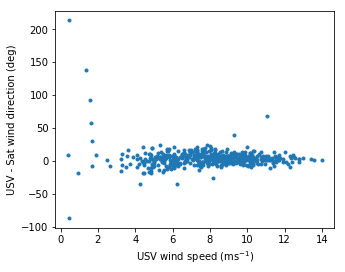

In [101]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,sat_dir-usv_dir,'.')
ax.set_xlabel('USV wind speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat wind direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_wdir_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


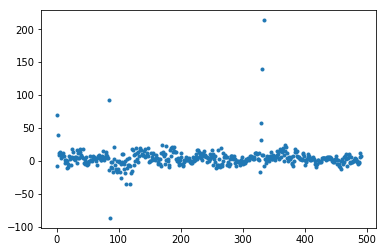

In [102]:
plt.plot(sat_dir-usv_dir,'.')

In [ ]:
#faster not sure why
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu,dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.uwnd[index]):
        continue
    test = ds_collocated_nearest.where((ds_tem.uwnd==ds_collocated_nearest.uwnd[index])&(ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
    test = test/test
    if test.uwnd.sum()>0:
        duu=np.append(duu,(ds_usv_subset.UWND_MEAN*test.uwnd).mean().data)
        dvu=np.append(dvu,(ds_usv_subset.VWND_MEAN*test.vwnd).mean().data)
        dlat=np.append(dlat,(ds_usv_subset.lat*test.lat).mean().data)
        dlon=np.append(dlon,(ds_usv_subset.lon*test.lon).mean().data)
        tdif = ds_usv_subset.time.where(test.vwnd==1).max().data-ds_usv_subset.time.where(test.vwnd==1).min().data
        mtime=ds_usv_subset.time.where(test.vwnd==1).min().data+np.timedelta64(tdif/2,'ns')
        dut=np.append(dut,mtime)
        ds_tem=ds_tem.where(np.isnan(test),np.nan)  #you have used values, so set to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new2=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})


In [ ]:
#testing code above
ds_tem = ds_collocated_nearest.copy(deep=True)
print(ds_collocated_nearest.uwnd[1055].data)
print(ds_collocated_nearest.uwnd[1050:1150].data)
test = ds_collocated_nearest.where((ds_collocated_nearest.uwnd==ds_collocated_nearest.uwnd[1055])&(ds_collocated_nearest.vwnd==ds_collocated_nearest.vwnd[1055]))
test = test/test
print(test.uwnd[1050:1150].data)
ds_tem=ds_tem.where(np.isnan(test),np.nan)
print(ds_tem.uwnd[1050:1150].data)
print((ds_usv_subset.UWND_MEAN*test.uwnd).mean())
print((ds_usv_subset.VWND_MEAN*test.vwnd).mean())


In [ ]:
from scipy.interpolate import griddata
# interpolate
points = (ds_usv_subset.lon.data,ds_usv_subset.lat.data)
grid_in_lon,grid_in_lat = np.meshgrid(subset.lon.data,subset.lat.data)
grid_in = (grid_in_lon,grid_in_lat)
values = ds_usv_subset.UWND_MEAN.data
#print(points.size)
zi = griddata(points,values,grid_in,method='linear',fill_value=np.nan)
zi2 = griddata(points,values/values,grid_in,method='linear',fill_value=np.nan)
print(np.isfinite(zi).sum())

In [ ]:
plt.pcolormesh(subset.lon,subset.lat,zi,vmin=-5,vmax=5)
plt.plot(ds_usv_subset.lon,ds_usv_subset.lat,'.')
#plt.contourf(subset.uwnd[0,:,:])

In [ ]:
len(points[0])

In [ ]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

THRESHOLD=1
# Construct kd-tree, functionality copied from scipy.interpolate
tree = cKDTree(points)
xi = _ndim_coords_from_arrays(grid_in, ndim=len(points[0]))
dists, indexes = tree.query(xi)

# Copy original result but mask missing values with NaNs
result3 = result2[:]
result3[dists > THRESHOLD] = np.nan

# Show
plt.figimage(result3)
plt.show()

In [ ]:
#testing
index=300
ds_tem = ds_collocated_nearest.copy(deep=True)
cond = ((ds_tem.uwnd==ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd==ds_collocated_nearest.vwnd[index]))
notcond = ((ds_tem.uwnd!=ds_collocated_nearest.uwnd[index]) & (ds_tem.vwnd!=ds_collocated_nearest.vwnd[index]))
masked = ds_tem.where(cond)
masked_usv = ds_usv_subset.where(cond,drop=True)
print(masked.uwnd.sum().data)
#print(masked.nobs[290:310].data)
print((masked_usv.UWND_MEAN).mean().data)
print(ds_tem.uwnd[243:316])
ds_tem=ds_tem.where(notcond,np.nan)  #you have used values, so set to nan
print(ds_tem.uwnd[243:316])
